In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import xgboost as xgb
from sklearn.metrics import confusion_matrix


In [2]:
data = pd.read_csv("/content/new-data.csv")

In [3]:
data.head()
reg_data = data.copy()

In [ ]:
# Remove previous grades keeping only G1
data = data.drop(columns=['G2', 'G3'])
grade_category_unique_values = data['Grade_Category'].unique()

data_types = data.dtypes
grade_category_unique_values, data_types

In [ ]:
# encoding cat variables
le = LabelEncoder()
columns_to_encode = data.select_dtypes(include=['object']).columns.drop('Grade_Category')
for column in columns_to_encode:
    data[column] = le.fit_transform(data[column])
data.head()

In [ ]:
# Performing 2-way Anova for all pairs of features, excluding 'Grade_Category_Num' itself
data['Grade_Category_Num'] = le.fit_transform(data['Grade_Category'])
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

feature_pairs = itertools.combinations(numeric_columns.drop('Grade_Category_Num'), 2)
anova_results = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'F-Statistic', 'p-Value'])
for pair in feature_pairs:
    formula = f'Grade_Category_Num ~ C({pair[0]}) + C({pair[1]}) + C({pair[0]}):C({pair[1]})'
    model = ols(formula, data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    interaction_effect = aov_table.loc[f'C({pair[0]}):C({pair[1]})']
    if interaction_effect['PR(>F)'] < 0.05:
        new_row = pd.DataFrame({
            'Feature_1': [pair[0]],
            'Feature_2': [pair[1]],
            'F-Statistic': [interaction_effect['F']],
            'p-Value': [interaction_effect['PR(>F)']]
        })
        anova_results = pd.concat([anova_results, new_row], ignore_index=True)

In [ ]:
# Sort results by F-Statistic
anova_results_sorted = anova_results.sort_values(by='F-Statistic', ascending=False)
anova_results_sorted.head()


<ipython-input-8-00de31a5a7bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_anova_results['Interaction'] = top_anova_results['Feature_1'] + ' & ' + top_anova_results['Feature_2']


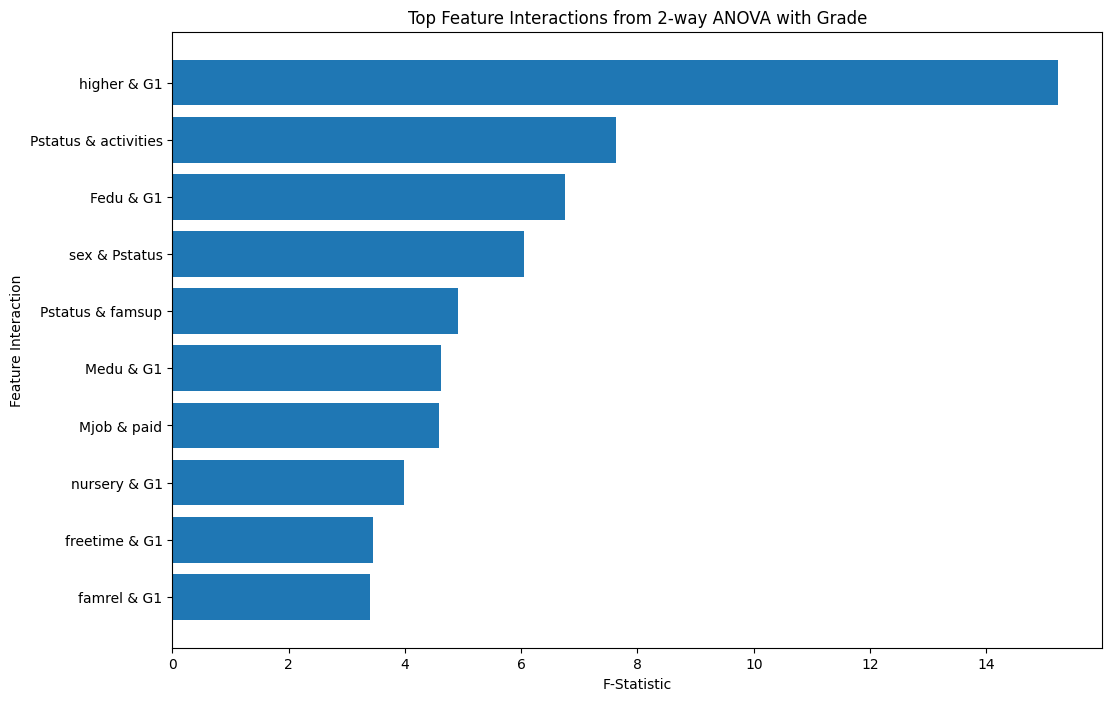

In [8]:
top_anova_results = anova_results_sorted.head(10)
top_anova_results['Interaction'] = top_anova_results['Feature_1'] + ' & ' + top_anova_results['Feature_2']
plt.figure(figsize=(12, 8))
plt.barh(top_anova_results['Interaction'], top_anova_results['F-Statistic'])
plt.xlabel('F-Statistic')
plt.ylabel('Feature Interaction')
plt.title('Top Feature Interactions from 2-way ANOVA with Grade')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
for index, row in top_anova_results.iterrows():
    feature_1 = row['Feature_1']
    feature_2 = row['Feature_2']
    interaction_feature_name = f'{feature_1}_x_{feature_2}'
    data[interaction_feature_name] = data[feature_1] * data[feature_2]
data.head()


In [10]:
X = data.drop(columns=['Grade_Category', 'Grade_Category_Num'])
y = data['Grade_Category_Num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
top_features = feature_importances.nlargest(20, 'Importance')['Feature']

# Select only the top features for X_train and X_test
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


In [11]:
# Assuming 'le' is your LabelEncoder object and 'y2' is the encoded array
original_labels = le.inverse_transform(y.unique())

print("Unique encoded labels:", y.unique())
print("Corresponding original labels:", original_labels)


Unique encoded labels: [1 0 2]
Corresponding original labels: ['Fail' 'At_risk' 'Pass']


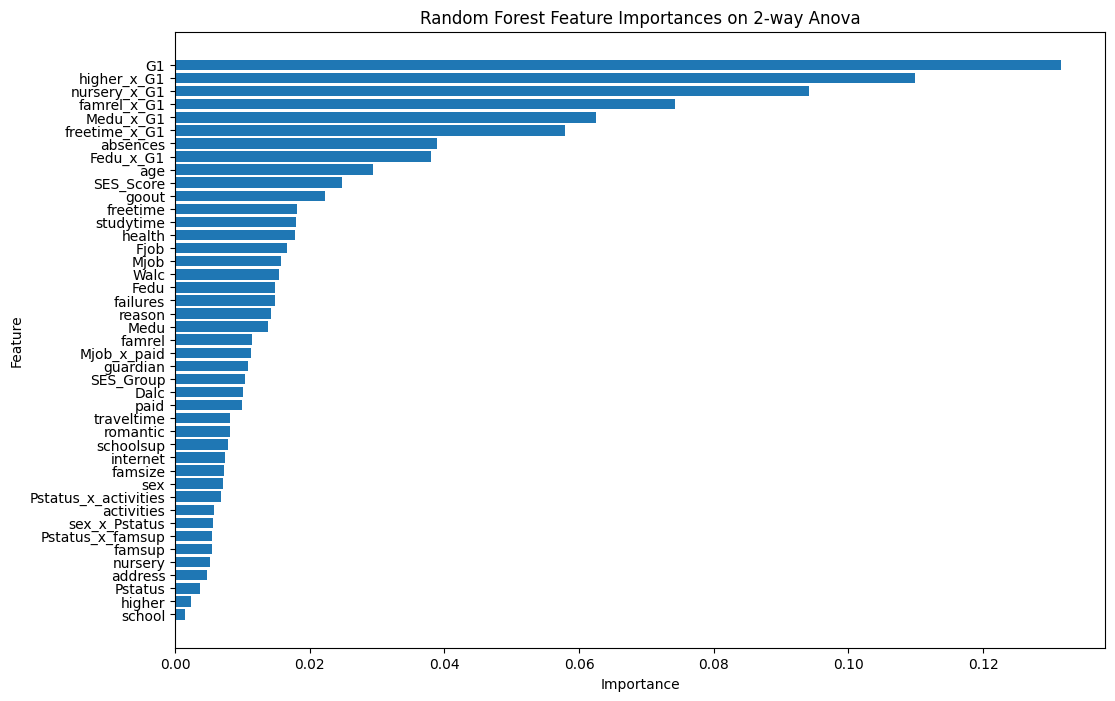

In [ ]:
# Sort the DataFrame by importance
importance_df = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances on 2-way Anova')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# function to evaluate models
def evaluate_model(model, model_name, X_train, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))
    y_pred_prob = model.predict_proba(X_test)
    print(f'{model_name} Prediction Probabilities (First 5 Predictions):')
    print(y_pred_prob[:5])
    print('-' * 50)

In [ ]:
# evaluate Grid and Randomised search
def evaluate_search(search_obj, search_type, X_test, y_test):
    print(f"Best parameters found by {search_type}: ", search_obj.best_params_)
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print(f'Classification Report of the best model ({search_type}):')
    print(classification_report(y_test, y_pred))
    y_pred_prob = best_model.predict_proba(X_test)
    print(f'Prediction Probabilities (First 5 Predictions) of the best model ({search_type}):')
    print(y_pred_prob[:5])
    print('-' * 50)

In [ ]:
# fitting the initial model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_top, y_train)


In [ ]:
evaluate_model(rf_classifier, 'Random Forest', X_train_top, X_test_top, y_test)
#Random Forest Accuracy: 0.7974683544303798

In [ ]:
# Create the pipeline for RF models
rf_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_pipeline,
                           param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

grid_search.fit(X_train_top, y_train)


In [ ]:
evaluate_search(grid_search, "GridSearch RF", X_test_top, y_test)
#Accuracy of the best model: 0.7848101265822784

In [ ]:
param_dist = {
    'rf__n_estimators': randint(50, 200),
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 4),
    'rf__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='accuracy'
)

random_search.fit(X_train_top, y_train)


In [ ]:
evaluate_search(random_search, "RandomizedSearchCV on RF", X_test_top, y_test)
#Accuracy of the best model: 0.7721518987341772

Best parameters found by RandomizedSearchCV on RF:  {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 7, 'rf__n_estimators': 102}
Accuracy of the best model: 0.7721518987341772
Classification Report of the best model (RandomizedSearchCV on RF):
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        32
           1       0.75      0.89      0.81        27
           2       0.88      0.75      0.81        20

    accuracy                           0.77        79
   macro avg       0.79      0.78      0.78        79
weighted avg       0.78      0.77      0.77        79

Prediction Probabilities (First 5 Predictions) of the best model (RandomizedSearchCV on RF):
[[0.29555959 0.70335109 0.00108932]
 [0.59187974 0.10078976 0.3073305 ]
 [0.09241186 0.90758814 0.        ]
 [0.50096731 0.49903269 0.        ]
 [0.40416667 0.59093137 0.00490196]]
------------------------------------------------

## AdaBoost model with RF as base


In [ ]:
base_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
ada_boost_rf = AdaBoostClassifier(estimator=base_rf, random_state=42, n_estimators=50)
ada_boost_rf.fit(X_train_top, y_train)


In [ ]:
evaluate_model(ada_boost_rf,'AdaBoost', X_train_top, X_test_top, y_test)
#AdaBoost Accuracy: 0.7848101265822784

In [ ]:
ada_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('ada_boost_rf', AdaBoostClassifier(
        estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
        random_state=42))
])

param_dist = {
    'ada_boost_rf__n_estimators': randint(30, 100),
    'ada_boost_rf__learning_rate': [0.01, 0.1, 1]
}

random_search = RandomizedSearchCV(
    ada_pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_top, y_train)


In [ ]:
evaluate_search(random_search, 'RandomizedSearchCV', X_test_top, y_test)
#Accuracy of the best model: 0.810126582278481

Best parameters found by RandomizedSearchCV:  {'ada_boost_rf__learning_rate': 1, 'ada_boost_rf__n_estimators': 81}
Accuracy of the best model: 0.810126582278481
Classification Report of the best model (RandomizedSearchCV):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        32
           1       0.83      0.89      0.86        27
           2       0.88      0.75      0.81        20

    accuracy                           0.81        79
   macro avg       0.82      0.81      0.81        79
weighted avg       0.81      0.81      0.81        79

Prediction Probabilities (First 5 Predictions) of the best model (RandomizedSearchCV):
[[3.60000000e-01 6.40000000e-01 2.22044605e-16]
 [7.60000000e-01 1.00000000e-01 1.40000000e-01]
 [1.20000000e-01 8.80000000e-01 2.22044605e-16]
 [5.30000000e-01 4.70000000e-01 2.22044605e-16]
 [3.20000000e-01 6.80000000e-01 2.22044605e-16]]
--------------------------------------------------


## XGB

In [ ]:
# Create the pipeline for XGB models
xgb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(objective='multi:softmax', random_state=42))
])

param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_xgb.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search_xgb, "XGB", X_test_top, y_test)
#Accuracy of the best model: 0.759493670886076

Best parameters found by XGB:  {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.7}
Accuracy of the best model: 0.759493670886076
Classification Report of the best model (XGB):
              precision    recall  f1-score   support

           0       0.78      0.56      0.65        32
           1       0.68      0.93      0.78        27
           2       0.89      0.85      0.87        20

    accuracy                           0.76        79
   macro avg       0.78      0.78      0.77        79
weighted avg       0.77      0.76      0.75        79

Prediction Probabilities (First 5 Predictions) of the best model (XGB):
[[0.2524476  0.58843505 0.15911736]
 [0.4872643  0.23046233 0.2822733 ]
 [0.18616445 0.66038793 0.15344769]
 [0.37037835 0.44260263 0.18701895]
 [0.2946078  0.5438262  0.16156597]]
--------------------------------------------------


In [ ]:
# reruning gridsearch with the refined parameter grid
param_grid_xgb_refined = {
    'xgb__n_estimators': [100, 300, 500],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb_refined = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb_refined,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search_xgb_refined.fit(X_train_top, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      gr...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softmax', ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.7, 0.8, 0.9],
                         'xgb__learning_rate': [0.01, 0.05, 0.1],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 300, 500],
                         'xgb__subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=2)

In [ ]:
evaluate_search(grid_search_xgb_refined, "Gridsearch", X_test_top, y_test)
#Accuracy of the best model: 0.8227848101265823

Best parameters found by Gridsearch:  {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.9}
Accuracy of the best model: 0.8227848101265823
Classification Report of the best model (Gridsearch):
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        32
           1       0.75      0.89      0.81        27
           2       1.00      0.85      0.92        20

    accuracy                           0.82        79
   macro avg       0.85      0.83      0.84        79
weighted avg       0.83      0.82      0.82        79

Prediction Probabilities (First 5 Predictions) of the best model (Gridsearch):
[[0.20745726 0.77375406 0.01878866]
 [0.8743876  0.05421515 0.07139723]
 [0.03300379 0.96069837 0.00629778]
 [0.5661171  0.41014174 0.02374119]
 [0.14197512 0.8496561  0.00836886]]
--------------------------------------------------


## function to return full array of predictions

In [ ]:
def get_model_pred(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob


In [ ]:
def get_search_pred(search_obj, X_test, y_test):
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print("Classification Report of the best model:",{best_model})
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob

In [ ]:
# collecting the data
y_test1, y_pred1, y_pred_prob1 = get_model_pred(rf_classifier, X_test_top, y_test)
y_test_gs1, y_pred_gs1, y_pred_prob_gs1 = get_search_pred(random_search, X_test_top, y_test)
y_test_gs2, y_pred_gs2, y_pred_prob_gs2 = get_search_pred(grid_search_xgb_refined, X_test_top, y_test)

Accuracy: 0.7974683544303798
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        32
           1       0.88      0.85      0.87        27
           2       0.92      0.60      0.73        20

    accuracy                           0.80        79
   macro avg       0.84      0.78      0.79        79
weighted avg       0.82      0.80      0.80        79

Accuracy of the best model: 0.810126582278481
Classification Report of the best model: {Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('ada_boost_rf',
                 AdaBoostClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42),
                                    learning_rate=1, n_estimators=81,
                                    random_state=42))])}
              precision    recall  f1-score   support

  

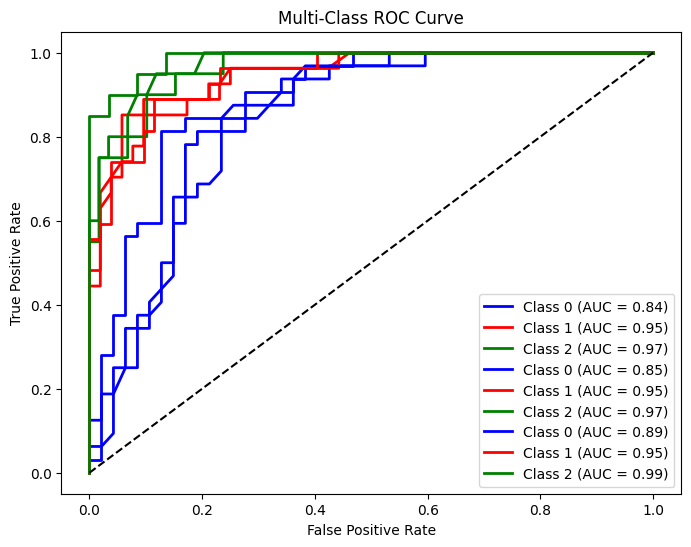

In [ ]:
# Function to plot ROC curve for each class
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

def plot_multiclass_roc(y_true, y_pred_prob, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.figure(figsize=(8, 6))
plot_multiclass_roc(y_test_binarized, y_pred_prob1, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs1, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs2, n_classes)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


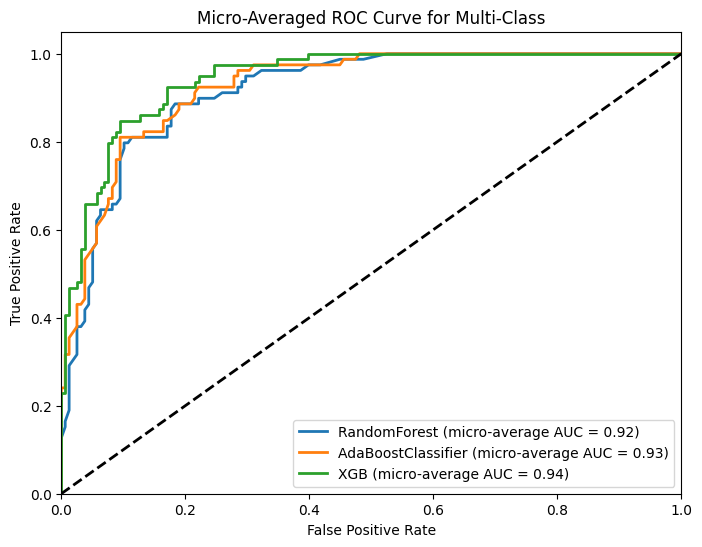

In [ ]:
# Function to plot ROC curve for each model with micro-averaging
def plot_micro_averaged_roc_curve(y_true, y_score, n_classes, ax, name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # micro-average ROC curve & ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    ax.plot(fpr["micro"], tpr["micro"],
            label=f'{name} (micro-average AUC = {roc_auc["micro"]:0.2f})',
            linestyle='-', linewidth=2)


fig, ax = plt.subplots(figsize=(8, 6))
# score arrays from best models
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob1, n_classes, ax, 'RandomForest')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs1, n_classes, ax, 'AdaBoostClassifier')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs2, n_classes, ax, 'XGB')
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Micro-Averaged ROC Curve for Multi-Class')
ax.legend(loc="lower right")
plt.show()

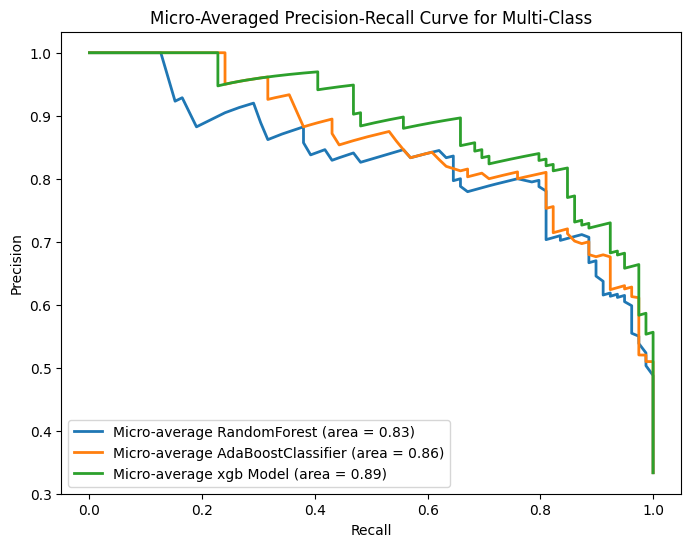

In [ ]:
# Function to plot Precision-Recall curve for each model with micro-averaging
def plot_micro_averaged_precision_recall_curve(y_true, y_score, n_classes, ax, name):
    precision = dict()
    recall = dict()
    average_precision = dict()

    # micro-average precision-recall & AUC
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true, y_score, average="micro")

    ax.plot(recall["micro"], precision["micro"], lw=2,
             label=f'Micro-average {name} (area = {average_precision["micro"]:0.2f})')

fig, ax = plt.subplots(figsize=(8, 6))
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob1, n_classes, ax, 'RandomForest')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs1, n_classes, ax, 'AdaBoostClassifier')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs2, n_classes, ax, 'xgb Model')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Micro-Averaged Precision-Recall Curve for Multi-Class')
ax.legend(loc="lower left")
plt.show()

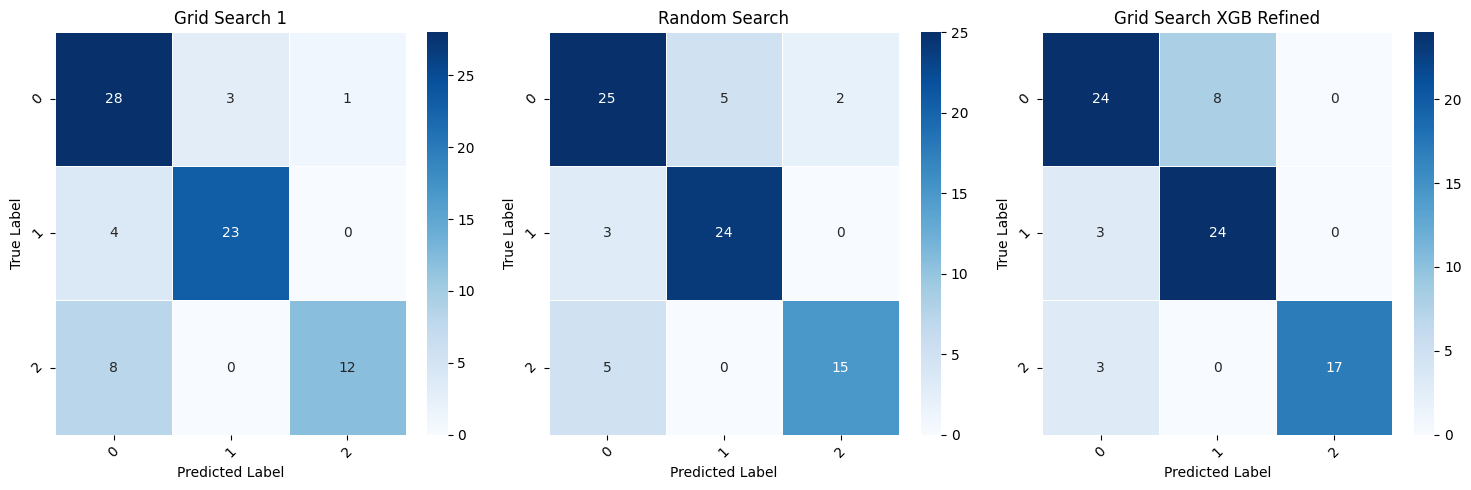

In [ ]:
# Function to plot the confusion matrix of best models
def plot_confusion_matrix(cm, classes, title, ax, cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, ax=ax, cmap=cmap)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title=title)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
class_labels = np.unique(y_test)
predictions = [
    (y_test1, y_pred1, 'Grid Search 1'),
    (y_test_gs1, y_pred_gs1, 'Random Search'),
    (y_test_gs2, y_pred_gs2, 'Grid Search XGB Refined'),
]

for i, (y_test, y_pred, title) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i]
    plot_confusion_matrix(cm, class_labels, title, ax)

plt.tight_layout()
plt.show()
